### CPPN in pytorch

This code is initially based on https://github.com/johnguibas/cppn-art/blob/master/cppn.ipynb but optimized to use batching to speedup the generation of images.

Also inspired by Otoro http://blog.otoro.net/2016/03/25/generating-abstract-patterns-with-tensorflow/

In [14]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import uuid

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assume that we are on a CUDA machine, then this should print a CUDA device:
print(device)

cuda:0


In [16]:
x_dim = 60
y_dim = 60
z_dim = 60
l_dim = 8

img_size = x_dim*y_dim*z_dim
scale = 0.4

In [26]:
from torch.autograd import Variable

class net(nn.Module):
    def __init__(self, x_dim, y_dim, z_dim, l_dim, output_dim=1, batch_size=1):
        super(net, self).__init__()
        
        self.batch_size = batch_size
        self.image_size = x_dim*y_dim*z_dim
        self.l_dim = l_dim
        
        self.ln11 = nn.Linear(1, 32)
        self.ln12 = nn.Linear(1, 32)
        self.ln13 = nn.Linear(1, 32)
        self.ln14 = nn.Linear(1, 32)
        self.ln15 = nn.Linear(l_dim, 32)
        
        self.ln2 = nn.Linear(32, 32, bias=False)
        self.ln3 = nn.Linear(32, 32, bias=False)
        self.ln4 = nn.Linear(32, output_dim, bias=False)
        
        torch.nn.init.xavier_uniform_(self.ln11.weight)
        torch.nn.init.xavier_uniform_(self.ln12.weight)
        torch.nn.init.xavier_uniform_(self.ln13.weight)
        torch.nn.init.xavier_uniform_(self.ln14.weight)
        
        torch.nn.init.xavier_uniform_(self.ln2.weight)
        torch.nn.init.xavier_uniform_(self.ln3.weight)
        torch.nn.init.xavier_uniform_(self.ln4.weight)
        
        self.tanh1 = nn.Tanh()
        self.tanh2 = nn.Tanh()
        self.tanh3 = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, y, z, l, r):
        
        x = x.reshape([self.batch_size*self.image_size, 1])
        y = y.reshape([self.batch_size*self.image_size, 1])
        z = z.reshape([self.batch_size*self.image_size, 1])
        l = l.reshape([1, 1, l_dim])*torch.ones([self.image_size, 1])*scale
        
        r = r.reshape([self.batch_size*self.image_size, 1])
        
        #_input = torch.cat((x, y, z, r), dim=1)
        U = self.ln11(x) + self.ln12(y) + self.ln13(z) + self.ln14(r) + self.ln15(l)
        
        #U = self.ln1(_input)
        U = self.tanh1(U)
        U = self.ln2(U)
        U = self.tanh2(U)
        U = self.ln3(U)
        U = self.tanh3(U)
        U = torch.sin(self.ln4(U))
        return self.sigmoid(U)

G = net(x_dim, y_dim, z_dim, l_dim)

x, y, z = torch.meshgrid([torch.arange(0, x_dim).float()*scale, torch.arange(0, y_dim).float()*scale, torch.arange(0, z_dim).float()*scale])
l = torch.rand(l_dim)
print("Random vector")
r = ((x*scale-x_dim*scale/2)**2 + (y*scale-y_dim*scale/2)**2 + (z*scale-z_dim*scale/2)**2).float().sqrt()
image = G.forward(x, y, z, l, r)

Random vector


In [29]:
def save_obj(name, verts, normals, faces):
    with open(name, 'w') as f:
        for item in verts:
            f.write("v {0} {1} {2}\n".format(item[0],item[1],item[2]))
        
        for item in normals:
            f.write("vn {0} {1} {2}\n".format(item[0],item[1],item[2]))

        for item in faces:
            f.write("f {0}//{0} {1}//{1} {2}//{2}\n".format(item[0]+1,item[1]+1,item[2]+1))
            
for i in range(20):
    l += 1
    image = G.forward(x, y, z, l, r)
    verts, faces, normals, values = measure.marching_cubes_lewiner(image.reshape([x_dim, y_dim, z_dim]).data.numpy())
    print(i)
    save_obj("iter_{}.obj".format(i), verts, normals, faces)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


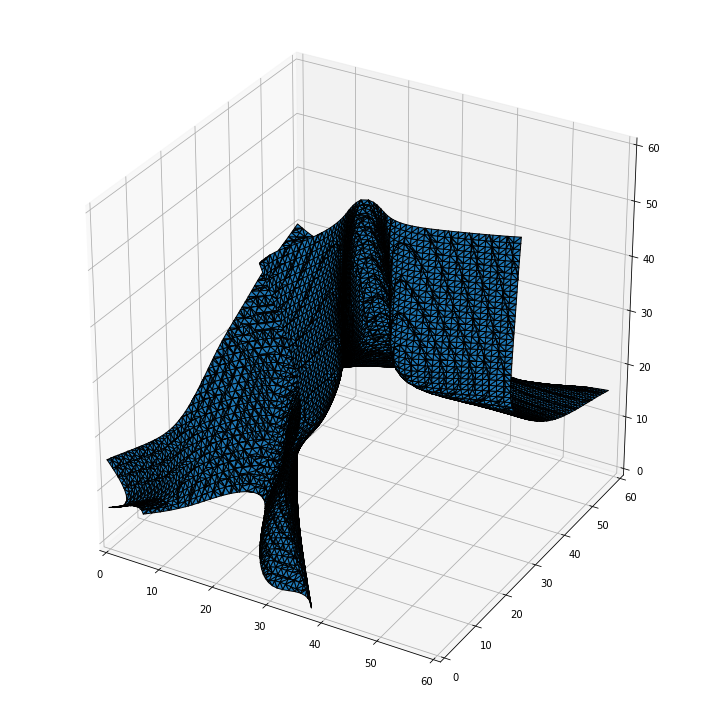

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from skimage import measure
from skimage.draw import ellipsoid


# Generate a level set about zero of two identical ellipsoids in 3D
ellip_base = ellipsoid(6, 10, 16, levelset=True)
ellip_double = np.concatenate((ellip_base[:-1, ...],
                               ellip_base[2:, ...]), axis=0)

# Use marching cubes to obtain the surface mesh of these ellipsoids
verts, faces, normals, values = measure.marching_cubes_lewiner(image.reshape([x_dim, y_dim, z_dim]).data.numpy())
x,y,z = zip(*verts)

with open('test.obj', 'w') as f:
    for item in verts:
        f.write("v {0} {1} {2}\n".format(item[0],item[1],item[2]))
        
    for item in normals:
        f.write("vn {0} {1} {2}\n".format(item[0],item[1],item[2]))

    for item in faces:
        f.write("f {0}//{0} {1}//{1} {2}//{2}\n".format(item[0]+1,item[1]+1,item[2]+1))  


# Display resulting triangular mesh using Matplotlib. This can also be done
# with mayavi (see skimage.measure.marching_cubes_lewiner docstring).
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces])
mesh.set_edgecolor('k')
ax.add_collection3d(mesh)

ax.set_xlim(0, x_dim)  # a = 6 (times two for 2nd ellipsoid)
ax.set_ylim(0, y_dim)  # b = 10
ax.set_zlim(0, z_dim)  # c = 16

plt.tight_layout()
plt.show()